In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
import os
os.chdir(r'C:\Users\thoma\OneDrive - stevens.edu\Documents\GitHub\CS513_Project')

In [3]:
df = pd.read_csv('test.csv', na_values='?')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.dropna()

In [4]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [5]:
#Feature engineering

#Total delay rather than 
df['Total Delay'] = df['Departure Delay in Minutes'] + df['Arrival Delay in Minutes']

#Turns delay into a categorical feature 
def bucket_total_delay(minutes):
    if minutes <= 15:
        return 'On Time'
    elif minutes <= 60:
        return 'Small Delay'
    else:
        return 'Big Delay'

# Apply the function to create a new feature
df['Delay Category'] = df['Total Delay'].apply(bucket_total_delay)

def bucket_rating(x):
    if x <= 2:
        return 'Low'
    elif x == 3:
        return 'Medium'
    else:
        return 'High'

rating_columns = [ 'Inflight wifi service','Food and drink', 'Seat comfort',
                  'Inflight entertainment', 'On-board service', 'Leg room service',
                  'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

for col in rating_columns:
    df[col] = df[col].apply(bucket_rating)




In [6]:
attr = df.drop(columns=['satisfaction','id'])
target = df['satisfaction']

# Test/Train split
attr_train, attr_test, target_train, target_test = train_test_split(attr, target, test_size=0.2, random_state=5)
categorical_columns = [
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class',
    'Inflight wifi service',
    'Food and drink',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Cleanliness',
    'Online boarding',
    'Delay Category'
]
# Create preprocessor for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns) ])
# Create Naive Bayes model
cnb = CategoricalNB()

# Create a pipeline with preprocessing and model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', cnb)])
#Perform grid search and smoothing
param_grid = {
    'classifier__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(attr_train, target_train)
print("Best alpha:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


# Train the model
model.fit(attr_train, target_train)

# # Make predictions on the test set
best_model = grid_search.best_estimator_
target_pred = best_model.predict(attr_test)

Best alpha: {'classifier__alpha': 0.001}
Best cross-validation accuracy: 0.8601909896012343


In [7]:
attr_test.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Total Delay,Delay Category
8918,Male,disloyal Customer,30,Business travel,Business,733,Low,2,2,4,...,High,Medium,High,High,4,Medium,81,61.0,142.0,Big Delay
3296,Male,Loyal Customer,42,Business travel,Business,1847,Medium,3,3,3,...,High,High,High,High,5,Medium,11,3.0,14.0,On Time
11036,Female,Loyal Customer,39,Business travel,Business,3965,Medium,3,3,3,...,High,High,High,Low,4,High,0,0.0,0.0,On Time
9981,Male,Loyal Customer,40,Business travel,Eco,773,Medium,3,3,3,...,High,Medium,High,Medium,2,Medium,137,131.0,268.0,Big Delay
14854,Male,Loyal Customer,35,Business travel,Business,361,Medium,3,3,3,...,High,High,High,Medium,4,Medium,17,5.0,22.0,Small Delay


Accuracy: 0.87



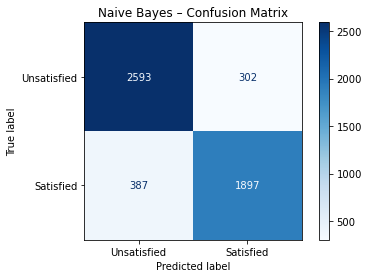


Classification Report:
              precision    recall  f1-score   support

 Unsatisfied       0.87      0.90      0.88      2895
   Satisfied       0.86      0.83      0.85      2284

    accuracy                           0.87      5179
   macro avg       0.87      0.86      0.86      5179
weighted avg       0.87      0.87      0.87      5179



In [9]:

# Evaluate the accuracy
accuracy = accuracy_score(target_test, target_pred)
print(f'Accuracy: {accuracy:.2f}\n')

# Compute the confusion matrix
cm = confusion_matrix(target_test, target_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unsatisfied', 'Satisfied'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Naive Bayes – Confusion Matrix')
plt.grid(False)
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(target_test, target_pred, target_names=['Unsatisfied', 'Satisfied']))
